# Training a commute prediction network, and visualizing learning!  
<ul> latest version available from: https://github.com/miroenev/teach_DL , prerequisites:
* Matplotlib, Numpy, MxNet, and <a href="https://github.com/K3D-tools/K3D-jupyter">K3D</a> for realtime training 3D surface visualization

A video walkthrough of this notebook is <a href='https://youtu.be/HgbGJn9yz30'> available on YouTube</a>.

In [11]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

In [12]:
%matplotlib notebook

In [13]:
import mxnet as mx

# Define the problem

Lets try to predict commute duration from two observable independent variables: the time of day and the weather conditions.

<img src='figures/commute.png' width='400'/>
<img src='figures/target_distribution.PNG' width='1000'/>
In this toy example we'll first take on the role of the 'traffic gods' and decree that commute duration is defined through a linear mixture of the two independent variables. Later we'll sample from the distribution defined by these variables and generate a training dataset. This sampling procedure will be analogous to keeping a journal of all of our commutes for some [ long ] period of time, where each log entry consists of a set of  
* <b>X</b>: [ time-of-departure, weather-condition ], and the associated  
* <b>Y</b>: [ commute-duration ].

<img src='figures/x_y_mapping.PNG' width='900'/>

Given such a journal [dataset], we'll split it into training (75%) and testing (25%) subsets which we'll use to train and evaulate our model respectively. Specifically, we'll build a neural network model whose weights are initially randomly initialized, but are trained/updated as we stream the training data through (via the backpropagation learning algorithm). Each update will get us closer to having a model that has learned the relationship between X and Y or ([ time-of-departure, weather-condition ] to [ commute-duration] ).

<img src='figures/process.PNG' width='800'/>

During the training process we'll try to visualize the network's behavior by asking it to predict all the entries in our logbook using its current parameters/weights. As the training process unfolds, you should be able to see how the network adapts itself to the target surface/function that we determined for the commute duration.

<img src='figures/training_progress.PNG' width='700'/>

# Determine underlying relationship
We'll start by esablishing (as traffic gods) the relationships between:  
* 1) the time a commute starts (time-of-departure variable) and commute-duration
* 2) the weather when a commute is started (weather-condtion variable) and commute-duration

Note that as data scientists we never get to see this function, but we try to learn it from data.

<IPython.core.display.Javascript object>


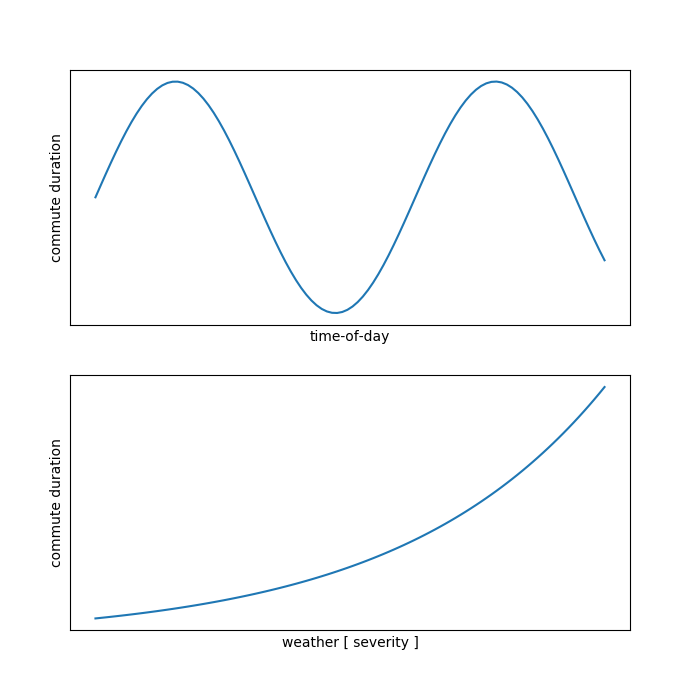

<IPython.core.display.Javascript object>


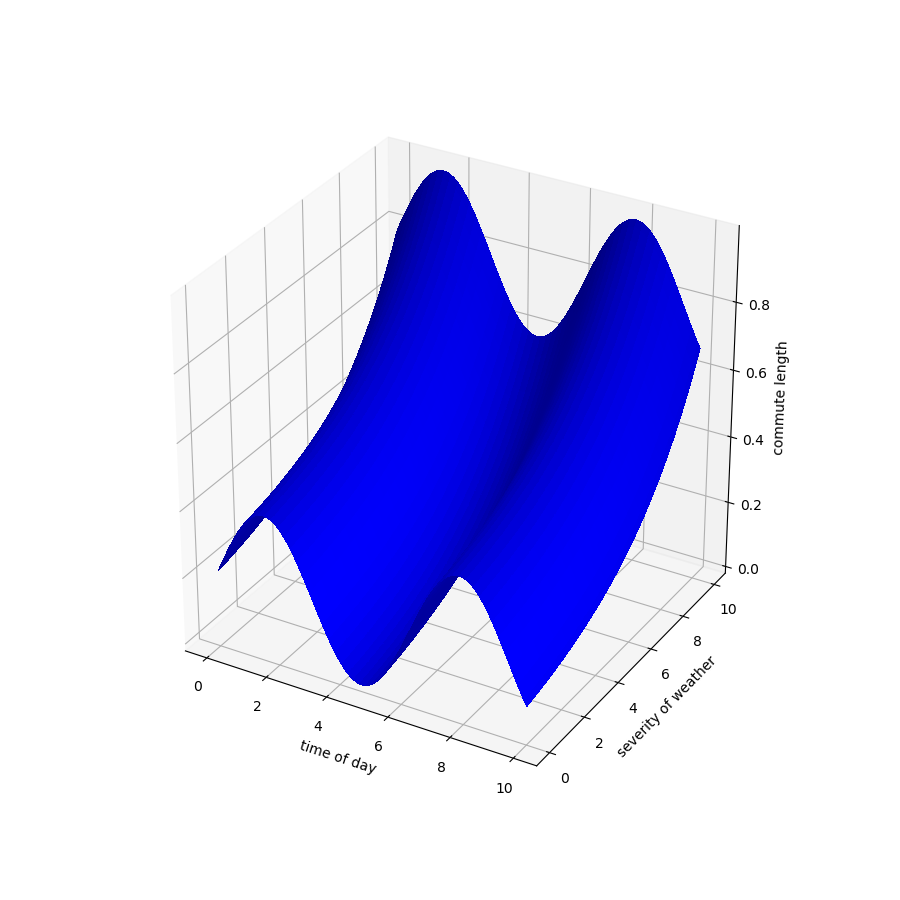

In [14]:
# define data coordinates
xRange = [0,10]; 
yRange = [0,10]; numSteps = 100

x, y = np.meshgrid( np.linspace(xRange[0], xRange[1], numSteps),
                    np.linspace(yRange[0], yRange[1], numSteps), indexing='ij' )

def normalize_domain (x):
    x = x + np.abs(np.min(x))
    x = x / (np.max(x) + .001)
    return x
    
# define 1D relationships to target
xComponent = np.sin( x ) * 4
yComponent = np.exp( y / 4 )

# define 2D joint distribution
z = xComponent + yComponent
z = normalize_domain(z)


# plot independent variables
plt.figure( figsize = ( 7, 7) )
plt.subplots_adjust( left = 0.1, right = 0.9, top = 0.9, bottom = 0.1, wspace = 0.2 )
plt.subplot(2,1,1); plt.plot(normalize_domain(xComponent[:,0])); plt.xlabel('time-of-day'), plt.ylabel('commute duration')
plt.xticks([]), plt.yticks([])
plt.subplot(2,1,2); plt.plot(normalize_domain(yComponent[0,:])); plt.xlabel('weather [ severity ]'), plt.ylabel('commute duration')
plt.xticks([]), plt.yticks([])

# plot target [dependent] variable
plt.figure( figsize = (9, 9) )
plt.subplots_adjust( left = 0.1, right = 0.9, top = 0.9, bottom = 0.1 )
ax = plt.subplot(1,1,1, projection='3d');
ax.plot_surface ( x[0::1], y[0::1], z[0::1], color = 'blue', alpha = 1, antialiased = False )
ax.set_xlabel('time of day')
ax.set_ylabel('severity of weather')
ax.set_zlabel('commute length')
plt.show()



# Generate  dataset
Lets generate a dataset by randomly sampling from the target distribution [ with some noise ].

In [15]:
NSamples = 5000
noiseScaling = 1/8.

shuffledDataIndsX = np.random.randint(x.shape[0], size=(NSamples,1))
shuffledDataIndsY = np.random.randint(y.shape[0], size=(NSamples,1))

trainData = np.zeros( ( NSamples, 2 ) )
targetValues = np.zeros( (NSamples, 1 ))
noiseAmount = noiseScaling * ( np.random.rand(NSamples) - .5 )

for iSample in range (NSamples):
    trainData[iSample, 0] = x[ shuffledDataIndsX[iSample], 0 ]
    trainData[iSample, 1] = y[ 0, shuffledDataIndsY[iSample] ]    
    targetValues[iSample] = z[ shuffledDataIndsX[iSample], shuffledDataIndsY[iSample] ] + noiseAmount[iSample]


# Plot dataset samples (red dots) overlayed onto target distribution (blue)

In [16]:
from k3d import K3D

plot = K3D()
zScaling = 6

offset = np.hstack( ( np.ones((trainData.shape[0], 1)) * -5, 
                      np.ones((trainData.shape[0], 1)) + 4, 
                      np.zeros((trainData.shape[0], 1)) ) ) * np.abs(xRange[1]-xRange[0])

plot += K3D.points ( np.hstack( ( trainData, targetValues*zScaling) ) + offset, color=0xFF0000, point_size = .2, shader = 'flat' )
plot += K3D.surface ( z*zScaling, color=0x0055FF, xmin=np.min(trainData[:,0]+offset[::,0]), xmax=np.max(trainData[:,0]+offset[::,0]), ymin=np.min(trainData[:,1]+offset[::,1]), ymax=np.max(trainData[:,1]+offset[::,1]))

plot.display()

K3D(parameters={'antialias': True, 'backgroundColor': 16777215, 'height': 512})

# Create Data Iterators

In [17]:
data = trainData
label = targetValues[:,0]

trainIterator = mx.io.NDArrayIter( data = data, label = label, 
                                   data_name = 'data', 
                                   label_name = 'linearOutput_label', batch_size = 512)

predictIterator = mx.io.NDArrayIter( data = data, label = label, 
                                     data_name = 'data', 
                                     label_name = 'linearOutput_label', batch_size = NSamples)


# Define model structure

In [18]:
import mxnet as mx

inputData = mx.sym.Variable('data')
targetLabelVar = mx.sym.Variable('linearOutput_label') 

layer1 = mx.sym.FullyConnected( data = inputData, name = 'fc1', num_hidden = 5)
layer1Activation = mx.sym.Activation( data = layer1, name = 'sig1', act_type = "sigmoid")

layer2 = mx.sym.FullyConnected( data = layer1Activation, name='fc2', num_hidden = 27)
layer2Activation = mx.sym.Activation( data = layer2, name='sig2', act_type = "sigmoid")

layer3 = mx.sym.FullyConnected( data = layer2Activation, name='fc3', num_hidden = 20)
layer3Activation = mx.sym.Activation( data = layer3, name='sig3', act_type = "sigmoid")

layer4 = mx.sym.FullyConnected( data = layer3Activation, name = 'fc4', num_hidden = 40)
layer4Activation = mx.sym.Activation( data = layer4, name = 'sig4', act_type = "sigmoid")

output = mx.sym.FullyConnected( data = layer4Activation, name='output', num_hidden=1)

loss = mx.sym.LinearRegressionOutput( data = output, label = targetLabelVar , name = 'linearOutput_label')

In [19]:
mod = mx.mod.Module(symbol = loss,
                    context = mx.gpu(0),
                    data_names = ['data'],
                    label_names = ['linearOutput_label'])

In [20]:
# allocate memory given the input data and label shapes
mod.bind( data_shapes = trainIterator.provide_data, label_shapes = trainIterator.provide_label )

RuntimeError: simple_bind error. Arguments:
data: (512, 2)
linearOutput_label: (512,)
[21:27:11] C:\projects\mxnet-distro-win\mxnet-build\src\storage\storage.cc:118: Compile with USE_CUDA=1 to enable GPU usage

In [ ]:
# initialize parameters by uniform random numbers
mod.init_params( initializer = mx.init.Xavier(), force_init = True)

In [ ]:
# use adam optimizer
mod.init_optimizer( optimizer = 'adam' )

In [ ]:
# use root mean squared error as the metric
metric = mx.metric.create( 'rmse' )

# Visualize network structure

In [ ]:
mx.viz.plot_network( loss )

In [ ]:
import importlib
import nnViz_mxnet
importlib.reload(nnViz_mxnet)

In [ ]:
nnViz_mxnet.visualize_model(mod)

Model structure [loosely] inspired by NVIDIA's new HQ ;]  
http://c.ymcdn.com/sites/aiascv.org/resource/resmgr/meeting_images/2017/March/Nv2.jpeg

# Train Model v1

In [ ]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
mod.fit(data_iter,
          optimizer = 'adam',`
          eval_metric = 'rmse',
          num_epoch = 50)

# Train Model v2

In [ ]:
# time ...
for epoch in range(100):
    
    trainIterator.reset()
    metric.reset()
    
    for batch in trainIterator:
        
        mod.forward( batch, is_train = True )       # compute predictions
        mod.update_metric( metric, batch.label )    # accumulate prediction accuracy
        mod.backward()                              # compute gradients
        mod.update()                                # update parameters
    
    print('Epoch %d, Training %s' % (epoch, metric.get()))

# Train Model + Visualize

In [ ]:
# initialize parameters by uniform random numbers
mod.init_params( initializer = mx.init.Xavier(), force_init = True)

In [ ]:

NEpochs = 350
displayUpdateInterval = 10

currentNN = {}
plotCount = 0

xOffset = np.zeros( (trainData.shape[0], 1))
yOffset = np.zeros( (trainData.shape[0], 1))
zOffset = np.zeros( (trainData.shape[0], 1))

xModifier = 1 * np.abs(xRange[1]-xRange[0])*1.2; yModifier = 0; zModifier = 0; 
plotCount = 0

evalLoss = np.empty((NEpochs))
evalLoss[:] = np.NaN

predictIterator.reset()
nextIterData = predictIterator.next()
batchInputs = nextIterData.data[0].asnumpy()


# train 5 epochs, i.e. going over the data iter one pass
for iEpoch in range(NEpochs):
    
    trainIterator.reset()
    metric.reset()
    
    for batch in trainIterator:
        mod.forward( batch, is_train = True )     # compute predictions
        mod.update_metric( metric, batch.label )  # accumulate prediction accuracy
        mod.backward()                            # compute gradients
        mod.update()                              # update parameters
    
    evalLoss[iEpoch] = metric.get()[1]
    print('Epoch: %d, Training Loss: %s' % ( iEpoch, evalLoss[iEpoch] ))
    
    
    # plotting 
    if iEpoch % displayUpdateInterval == 0:
        
        mod.forward( nextIterData )
        
        currentNN[plotCount] = mod.get_outputs()[0].asnumpy()

        comboOffset = np.hstack( (xOffset + xModifier, yOffset + yModifier, zOffset + zModifier) )
        plot += K3D.points ( np.hstack( ( batchInputs, currentNN[plotCount] * zScaling) ) + comboOffset + offset, color=0xA9A9FF, point_size = .2, shader = 'flat' )        
        plot += K3D.text2d ( str( round( evalLoss[iEpoch], 4 )), comboOffset + offset + (0, 0, 3), color=0xff00ff, size=.5, reference_point='rb')
        
        
        plotCount += 1
        if plotCount % 8 == 0:
            xModifier = 1 * np.abs(xRange[1]-xRange[0])*1.2
            yModifier -= 1 * np.abs(yRange[1]-yRange[0])*1.2
        else:
            xModifier += 1 * np.abs(xRange[1]-xRange[0])*1.2

In [ ]:
plt.figure()
plt.plot(evalLoss[:], 'b')
plt.plot(evalLoss[:], 'or')
plt.xlabel('epochs')
plt.ylabel('error')

# Plot Predictions Before Training

In [ ]:
plot = K3D()
plot += K3D.points ( np.hstack( ( batchInputs, targetValues*zScaling) ), color=0xFF0000, point_size = .1, shader = 'flat' )
plot += K3D.points ( np.hstack( ( batchInputs, currentNN[0]*zScaling) ), color=0xEE00EE, point_size = .3, shader = 'flat' )        
plot += K3D.surface ( z*zScaling, color=0x0000FF, xmin=np.min(xRange), xmax=np.max(xRange), ymin=np.min(yRange), ymax=np.max(yRange))
plot.display()

# Plot Predictions Midway Through Training

In [ ]:
plot = K3D()
plot += K3D.points ( np.hstack( ( batchInputs, targetValues*zScaling) ), color=0xFF0000, point_size = .1, shader = 'flat' )
plot += K3D.points ( np.hstack( ( batchInputs, currentNN[int(plotCount/2)]*zScaling) ), color=0xEE00EE, point_size = .3, shader = 'flat' )        
plot += K3D.surface ( z*zScaling, color=0x0000FF, xmin=np.min(xRange), xmax=np.max(xRange), ymin=np.min(yRange), ymax=np.max(yRange))
plot.display()

# Plot Predictions at End of Training

In [ ]:
plot = K3D()
plot += K3D.points ( np.hstack( ( batchInputs, targetValues*zScaling) ), color=0xFF0000, point_size = .1, shader = 'flat' )
plot += K3D.points ( np.hstack( ( batchInputs, currentNN[int(plotCount-1)]*zScaling) ), color=0xEE00EE, point_size = .3, shader = 'flat' )        
plot += K3D.surface ( z*zScaling, color=0x0000FF, xmin=np.min(xRange), xmax=np.max(xRange), ymin=np.min(yRange), ymax=np.max(yRange))
plot.display()

## thanks!